## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [2]:
!pip install torch torchvision torchaudio
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

# Функция для подсчета числа параметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cpu


In [9]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)    

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

100%|███████████████████████████████████████████████████████████████████████████████| 170M/170M [02:15<00:00, 1.26MB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


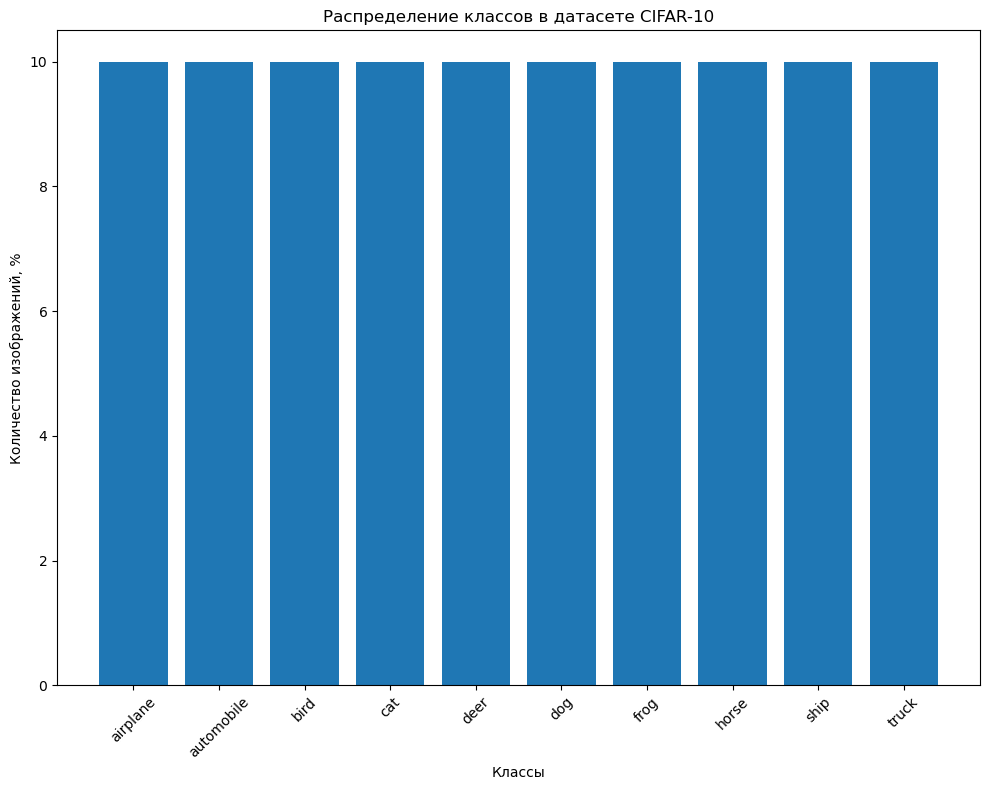

In [11]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)
# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))
# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1
class_counts = class_counts / class_counts.sum() * 100
# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


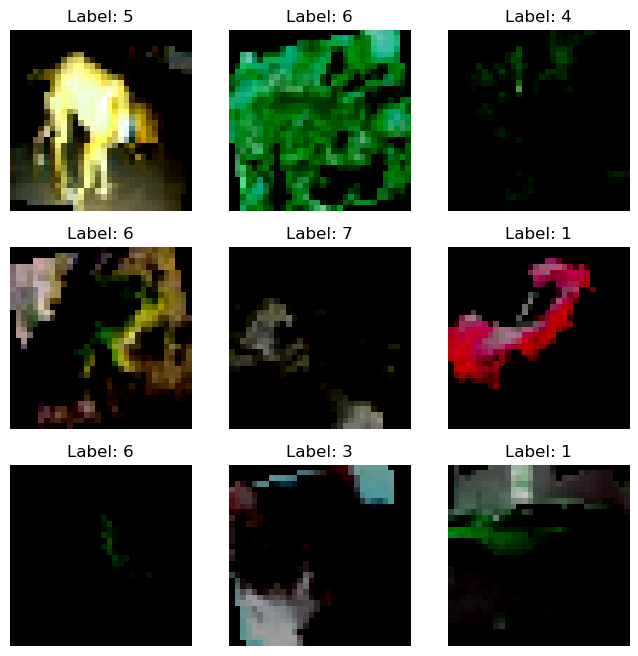

In [14]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?
Все 10 классов, таких как "airplane", "automobile", "bird" и другие, представлены равномерно, каждый примерно по 10% от общего числа изображений, что указывает на сбалансированность датасета и отсутствие проблемы несбалансированных классов. Разрешение изображений низкое — всего 32x32 пикселя, что соответствует стандарту CIFAR-10. Такое разрешение затрудняет их восприятие человеческим глазом, но делает их вполне подходящими для анализа с помощью моделей глубокого обучения. Некоторые изображения выглядят темными или необычно окрашенными, вероятно, из-за нормализации данных, где значения пикселей лежат в диапазоне [-1, 1]. Для корректной визуализации нормализацию следует преобразовать в диапазон [0, 1] или [0, 255]. Поскольку датасет сбалансирован, для оценки качества модели можно использовать accuracy (точность) в качестве основной метрики. Также полезно анализировать confusion matrix, чтобы понять, на каких классах модель ошибается чаще всего, например, при путанице между классами "cat" и "dog".

Напишем функции train и test

In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    
    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?
Разделение данных на train и test нужно, чтобы обучать модель на одной части данных (train) и проверять её качество на другой части (test), которую она не видела. Это помогает предотвратить переобучение и оценить способность модели обобщать закономерности на новых данных.

In [25]:
train_size = int(0.8 * len(train_dataset))  
val_size = len(train_dataset) - train_size  

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

In [27]:
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [29]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs)

Train epoch 1/50: 100%|█████████████| 625/625 [01:36<00:00,  6.48it/s, loss=1.7074, accuracy=0.3715]


Epoch 1/50 -> Train Loss: 1.7074, Train Acc: 0.3715, Val Loss: 1.4578, Val Acc: 0.4911


Train epoch 2/50: 100%|█████████████| 625/625 [01:34<00:00,  6.59it/s, loss=1.3818, accuracy=0.5006]


Epoch 2/50 -> Train Loss: 1.3818, Train Acc: 0.5006, Val Loss: 1.1225, Val Acc: 0.6019


Train epoch 3/50: 100%|█████████████| 625/625 [01:36<00:00,  6.49it/s, loss=1.2107, accuracy=0.5657]


Epoch 3/50 -> Train Loss: 1.2107, Train Acc: 0.5657, Val Loss: 1.0179, Val Acc: 0.6387


Train epoch 4/50: 100%|█████████████| 625/625 [01:33<00:00,  6.67it/s, loss=1.1071, accuracy=0.6028]


Epoch 4/50 -> Train Loss: 1.1071, Train Acc: 0.6028, Val Loss: 0.9299, Val Acc: 0.6674


Train epoch 5/50: 100%|█████████████| 625/625 [01:35<00:00,  6.54it/s, loss=1.0319, accuracy=0.6317]


Epoch 5/50 -> Train Loss: 1.0319, Train Acc: 0.6317, Val Loss: 0.8445, Val Acc: 0.7050


Train epoch 6/50: 100%|█████████████| 625/625 [01:34<00:00,  6.61it/s, loss=0.9829, accuracy=0.6534]


Epoch 6/50 -> Train Loss: 0.9829, Train Acc: 0.6534, Val Loss: 0.8078, Val Acc: 0.7160


Train epoch 7/50: 100%|█████████████| 625/625 [01:40<00:00,  6.22it/s, loss=0.9315, accuracy=0.6697]


Epoch 7/50 -> Train Loss: 0.9315, Train Acc: 0.6697, Val Loss: 0.7690, Val Acc: 0.7376


Train epoch 8/50: 100%|█████████████| 625/625 [01:41<00:00,  6.18it/s, loss=0.8877, accuracy=0.6866]


Epoch 8/50 -> Train Loss: 0.8877, Train Acc: 0.6866, Val Loss: 0.7657, Val Acc: 0.7343


Train epoch 9/50: 100%|█████████████| 625/625 [01:50<00:00,  5.64it/s, loss=0.8620, accuracy=0.6952]


Epoch 9/50 -> Train Loss: 0.8620, Train Acc: 0.6952, Val Loss: 0.7121, Val Acc: 0.7524


Train epoch 10/50: 100%|████████████| 625/625 [01:43<00:00,  6.04it/s, loss=0.8338, accuracy=0.7079]


Epoch 10/50 -> Train Loss: 0.8338, Train Acc: 0.7079, Val Loss: 0.7608, Val Acc: 0.7366


Train epoch 11/50: 100%|████████████| 625/625 [01:49<00:00,  5.70it/s, loss=0.7429, accuracy=0.7372]


Epoch 11/50 -> Train Loss: 0.7429, Train Acc: 0.7372, Val Loss: 0.6560, Val Acc: 0.7700


Train epoch 12/50: 100%|████████████| 625/625 [01:45<00:00,  5.90it/s, loss=0.7215, accuracy=0.7458]


Epoch 12/50 -> Train Loss: 0.7215, Train Acc: 0.7458, Val Loss: 0.6156, Val Acc: 0.7857


Train epoch 13/50: 100%|████████████| 625/625 [01:41<00:00,  6.16it/s, loss=0.6986, accuracy=0.7560]


Epoch 13/50 -> Train Loss: 0.6986, Train Acc: 0.7560, Val Loss: 0.6191, Val Acc: 0.7879


Train epoch 14/50: 100%|████████████| 625/625 [01:40<00:00,  6.21it/s, loss=0.6818, accuracy=0.7613]


Epoch 14/50 -> Train Loss: 0.6818, Train Acc: 0.7613, Val Loss: 0.6215, Val Acc: 0.7882


Train epoch 15/50: 100%|████████████| 625/625 [01:41<00:00,  6.17it/s, loss=0.6686, accuracy=0.7638]


Epoch 15/50 -> Train Loss: 0.6686, Train Acc: 0.7638, Val Loss: 0.6223, Val Acc: 0.7892


Train epoch 16/50: 100%|████████████| 625/625 [01:45<00:00,  5.94it/s, loss=0.6550, accuracy=0.7693]


Epoch 16/50 -> Train Loss: 0.6550, Train Acc: 0.7693, Val Loss: 0.5909, Val Acc: 0.7971


Train epoch 17/50: 100%|████████████| 625/625 [01:41<00:00,  6.14it/s, loss=0.6442, accuracy=0.7730]


Epoch 17/50 -> Train Loss: 0.6442, Train Acc: 0.7730, Val Loss: 0.5910, Val Acc: 0.7951


Train epoch 18/50: 100%|████████████| 625/625 [01:41<00:00,  6.18it/s, loss=0.6314, accuracy=0.7794]


Epoch 18/50 -> Train Loss: 0.6314, Train Acc: 0.7794, Val Loss: 0.5934, Val Acc: 0.8009


Train epoch 19/50: 100%|████████████| 625/625 [01:40<00:00,  6.20it/s, loss=0.6163, accuracy=0.7827]


Epoch 19/50 -> Train Loss: 0.6163, Train Acc: 0.7827, Val Loss: 0.5637, Val Acc: 0.8071


Train epoch 20/50: 100%|████████████| 625/625 [01:41<00:00,  6.13it/s, loss=0.6082, accuracy=0.7861]


Epoch 20/50 -> Train Loss: 0.6082, Train Acc: 0.7861, Val Loss: 0.5763, Val Acc: 0.8067


Train epoch 21/50: 100%|████████████| 625/625 [01:41<00:00,  6.15it/s, loss=0.5620, accuracy=0.8038]


Epoch 21/50 -> Train Loss: 0.5620, Train Acc: 0.8038, Val Loss: 0.5444, Val Acc: 0.8217


Train epoch 22/50: 100%|████████████| 625/625 [01:41<00:00,  6.16it/s, loss=0.5488, accuracy=0.8085]


Epoch 22/50 -> Train Loss: 0.5488, Train Acc: 0.8085, Val Loss: 0.5405, Val Acc: 0.8213


Train epoch 23/50: 100%|████████████| 625/625 [01:41<00:00,  6.15it/s, loss=0.5379, accuracy=0.8117]


Epoch 23/50 -> Train Loss: 0.5379, Train Acc: 0.8117, Val Loss: 0.5207, Val Acc: 0.8276


Train epoch 24/50: 100%|████████████| 625/625 [01:42<00:00,  6.08it/s, loss=0.5299, accuracy=0.8135]


Epoch 24/50 -> Train Loss: 0.5299, Train Acc: 0.8135, Val Loss: 0.5293, Val Acc: 0.8269


Train epoch 25/50: 100%|████████████| 625/625 [01:42<00:00,  6.12it/s, loss=0.5258, accuracy=0.8145]


Epoch 25/50 -> Train Loss: 0.5258, Train Acc: 0.8145, Val Loss: 0.5258, Val Acc: 0.8286


Train epoch 26/50: 100%|████████████| 625/625 [01:42<00:00,  6.11it/s, loss=0.5183, accuracy=0.8193]


Epoch 26/50 -> Train Loss: 0.5183, Train Acc: 0.8193, Val Loss: 0.5318, Val Acc: 0.8218


Train epoch 27/50: 100%|████████████| 625/625 [01:41<00:00,  6.13it/s, loss=0.5069, accuracy=0.8208]


Epoch 27/50 -> Train Loss: 0.5069, Train Acc: 0.8208, Val Loss: 0.5308, Val Acc: 0.8265


Train epoch 28/50: 100%|████████████| 625/625 [01:43<00:00,  6.07it/s, loss=0.5023, accuracy=0.8211]


Epoch 28/50 -> Train Loss: 0.5023, Train Acc: 0.8211, Val Loss: 0.5355, Val Acc: 0.8213


Train epoch 29/50: 100%|████████████| 625/625 [01:42<00:00,  6.08it/s, loss=0.4941, accuracy=0.8259]


Epoch 29/50 -> Train Loss: 0.4941, Train Acc: 0.8259, Val Loss: 0.5220, Val Acc: 0.8310


Train epoch 30/50: 100%|████████████| 625/625 [01:42<00:00,  6.08it/s, loss=0.4980, accuracy=0.8234]


Epoch 30/50 -> Train Loss: 0.4980, Train Acc: 0.8234, Val Loss: 0.5165, Val Acc: 0.8309


Train epoch 31/50: 100%|████████████| 625/625 [01:48<00:00,  5.78it/s, loss=0.4660, accuracy=0.8350]


Epoch 31/50 -> Train Loss: 0.4660, Train Acc: 0.8350, Val Loss: 0.5106, Val Acc: 0.8347


Train epoch 32/50: 100%|████████████| 625/625 [01:45<00:00,  5.91it/s, loss=0.4600, accuracy=0.8377]


Epoch 32/50 -> Train Loss: 0.4600, Train Acc: 0.8377, Val Loss: 0.5049, Val Acc: 0.8367


Train epoch 33/50: 100%|████████████| 625/625 [01:35<00:00,  6.58it/s, loss=0.4530, accuracy=0.8418]


Epoch 33/50 -> Train Loss: 0.4530, Train Acc: 0.8418, Val Loss: 0.5088, Val Acc: 0.8365


Train epoch 34/50: 100%|████████████| 625/625 [01:35<00:00,  6.53it/s, loss=0.4489, accuracy=0.8414]


Epoch 34/50 -> Train Loss: 0.4489, Train Acc: 0.8414, Val Loss: 0.5117, Val Acc: 0.8342


Train epoch 35/50: 100%|████████████| 625/625 [01:39<00:00,  6.28it/s, loss=0.4472, accuracy=0.8428]


Epoch 35/50 -> Train Loss: 0.4472, Train Acc: 0.8428, Val Loss: 0.4986, Val Acc: 0.8377


Train epoch 36/50: 100%|████████████| 625/625 [01:38<00:00,  6.33it/s, loss=0.4428, accuracy=0.8429]


Epoch 36/50 -> Train Loss: 0.4428, Train Acc: 0.8429, Val Loss: 0.4999, Val Acc: 0.8417


Train epoch 37/50: 100%|████████████| 625/625 [01:45<00:00,  5.90it/s, loss=0.4356, accuracy=0.8452]


Epoch 37/50 -> Train Loss: 0.4356, Train Acc: 0.8452, Val Loss: 0.5006, Val Acc: 0.8395


Train epoch 38/50: 100%|████████████| 625/625 [01:49<00:00,  5.69it/s, loss=0.4327, accuracy=0.8466]


Epoch 38/50 -> Train Loss: 0.4327, Train Acc: 0.8466, Val Loss: 0.4963, Val Acc: 0.8422


Train epoch 39/50: 100%|████████████| 625/625 [01:48<00:00,  5.77it/s, loss=0.4371, accuracy=0.8474]


Epoch 39/50 -> Train Loss: 0.4371, Train Acc: 0.8474, Val Loss: 0.4914, Val Acc: 0.8392


Train epoch 40/50: 100%|████████████| 625/625 [01:46<00:00,  5.87it/s, loss=0.4304, accuracy=0.8485]


Epoch 40/50 -> Train Loss: 0.4304, Train Acc: 0.8485, Val Loss: 0.5003, Val Acc: 0.8367


Train epoch 41/50: 100%|████████████| 625/625 [01:47<00:00,  5.79it/s, loss=0.4177, accuracy=0.8554]


Epoch 41/50 -> Train Loss: 0.4177, Train Acc: 0.8554, Val Loss: 0.4950, Val Acc: 0.8408


Train epoch 42/50: 100%|████████████| 625/625 [01:45<00:00,  5.91it/s, loss=0.4130, accuracy=0.8544]


Epoch 42/50 -> Train Loss: 0.4130, Train Acc: 0.8544, Val Loss: 0.4928, Val Acc: 0.8446


Train epoch 43/50: 100%|████████████| 625/625 [01:45<00:00,  5.95it/s, loss=0.4105, accuracy=0.8541]


Epoch 43/50 -> Train Loss: 0.4105, Train Acc: 0.8541, Val Loss: 0.4954, Val Acc: 0.8449


Train epoch 44/50: 100%|████████████| 625/625 [01:46<00:00,  5.88it/s, loss=0.4048, accuracy=0.8551]


Epoch 44/50 -> Train Loss: 0.4048, Train Acc: 0.8551, Val Loss: 0.4912, Val Acc: 0.8430


Train epoch 45/50: 100%|████████████| 625/625 [01:54<00:00,  5.47it/s, loss=0.3993, accuracy=0.8594]


Epoch 45/50 -> Train Loss: 0.3993, Train Acc: 0.8594, Val Loss: 0.4966, Val Acc: 0.8421


Train epoch 46/50: 100%|████████████| 625/625 [01:52<00:00,  5.53it/s, loss=0.3998, accuracy=0.8563]


Epoch 46/50 -> Train Loss: 0.3998, Train Acc: 0.8563, Val Loss: 0.4991, Val Acc: 0.8409


Train epoch 47/50: 100%|████████████| 625/625 [01:53<00:00,  5.51it/s, loss=0.3991, accuracy=0.8595]


Epoch 47/50 -> Train Loss: 0.3991, Train Acc: 0.8595, Val Loss: 0.5000, Val Acc: 0.8410


Train epoch 48/50: 100%|████████████| 625/625 [01:47<00:00,  5.82it/s, loss=0.3934, accuracy=0.8618]


Epoch 48/50 -> Train Loss: 0.3934, Train Acc: 0.8618, Val Loss: 0.4910, Val Acc: 0.8444


Train epoch 49/50: 100%|████████████| 625/625 [01:46<00:00,  5.86it/s, loss=0.3984, accuracy=0.8595]


Epoch 49/50 -> Train Loss: 0.3984, Train Acc: 0.8595, Val Loss: 0.4990, Val Acc: 0.8395


Train epoch 50/50: 100%|████████████| 625/625 [01:49<00:00,  5.71it/s, loss=0.3953, accuracy=0.8603]


Epoch 50/50 -> Train Loss: 0.3953, Train Acc: 0.8603, Val Loss: 0.4974, Val Acc: 0.8447


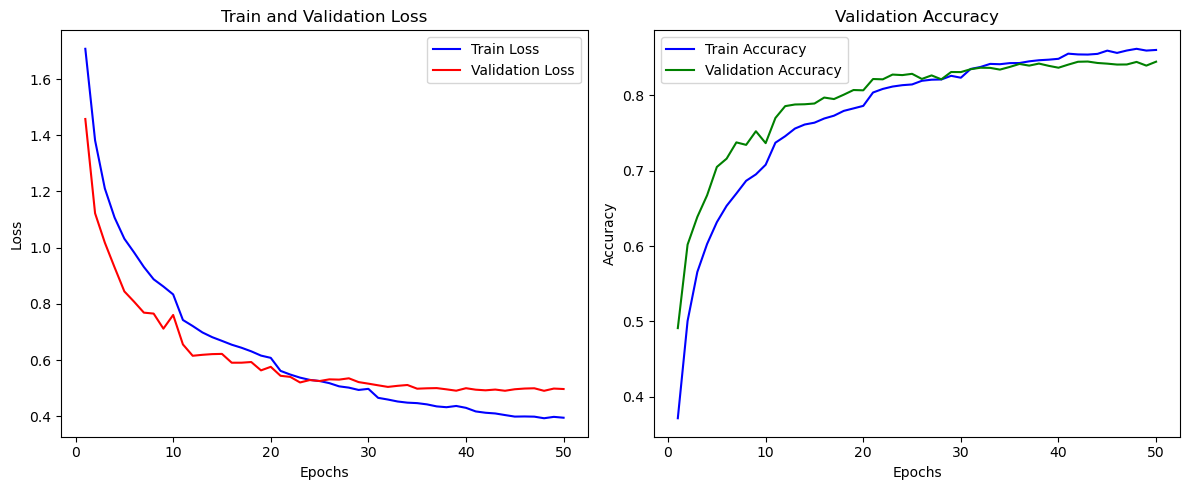

In [32]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Оцените тестовую метрику на тестовых данных

In [35]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4974
Test Accuracy: 0.8447


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов